# Inpainting missing data

Missing data in an image can be an issue, especially when one wants to perform Fourier analysis.
This tutorial explains how to fill-up missing pixels with values which looks "realistic" and introduce as little perturbation as possible for subsequent analysis.
The user should keep the mask nearby and only consider the values of actual pixels and never the one inpainted.

This tutorial will use fully synthetic data to allow comparison between actual (syntetic) data with inpainted values.

The first part of the tutorial is about the generation of a challenging 2D diffraction image with realistic noise and to describe the metric used, then comes the actual tutorial on how to use the inpainting. Finally a benchmark is used based on the metric determined.

## Creation of the image

A realistic challenging image should contain:

* Bragg peak rings. We chose LaB6 as guinea-pig, with very sharp peaks, at the limit of the resolution of the detector
* Some amorphous content
* strong polarization effect
* Poissonian noise


One image will be generated but then multiple ones with different noise to discriminate the effect of the noise from other effects.

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyFAI
print("Using pyFAI version: ", pyFAI.version)
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.gui import jupyter
import pyFAI.test.utilstest
from pyFAI.calibrant import get_calibrant
import time
start_time = time.time()

Using pyFAI version:  0.16.0-dev0


/users/kieffer/VirtualEnvs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
detector = pyFAI.detector_factory("Pilatus2MCdTe")
mask = detector.mask.copy()
nomask = numpy.zeros_like(mask)
detector.mask=nomask
ai = AzimuthalIntegrator(detector=detector)
ai.setFit2D(200, 200, 200)
ai.wavelength = 3e-11
print(ai)

Detector Pilatus CdTe 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 3.000000e-11m
SampleDetDist= 2.000000e-01m	PONI= 3.440000e-02, 3.440000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 200.000mm	Center: x=200.000, y=200.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


LaB6 Calibrant at wavelength 3e-11


<IPython.core.display.Javascript object>


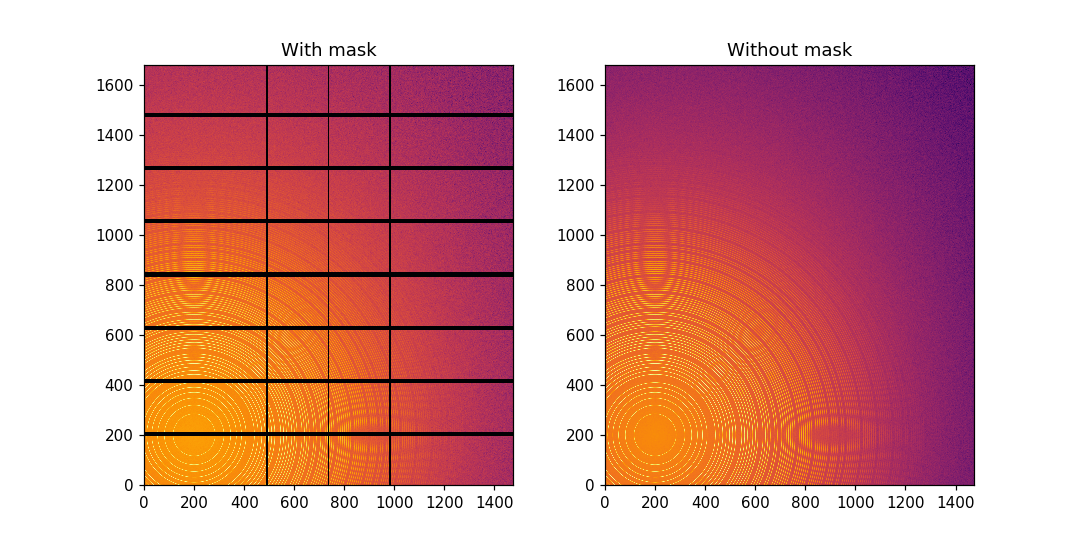

In [4]:
LaB6 = get_calibrant("LaB6")
LaB6.wavelength = ai.wavelength
print(LaB6)
r = ai.array_from_unit(unit="q_nm^-1")
decay_b = numpy.exp(-(r-50)**2/2000)
bragg = LaB6.fake_calibration_image(ai, Imax=1e4, W=1e-6) * ai.polarization(factor=1.0) * decay_b
decay_a = numpy.exp(-r/100)
amorphous = 1000*ai.polarization(factor=1.0)*ai.solidAngleArray() * decay_a
img_nomask = bragg + amorphous
#Not the same noise function for all images two images
img_nomask = numpy.random.poisson(img_nomask)
img_nomask2 = numpy.random.poisson(img_nomask)
img = numpy.random.poisson(img_nomask)
img[numpy.where(mask)] = -1
fig,ax = subplots(1,2, figsize=(10,5))
jupyter.display(img=img, label="With mask", ax=ax[0])
jupyter.display(img=img_nomask, label="Without mask", ax=ax[1])

Note the aliassing effect on the displayed images.

We will measure now the effect after 1D intergeration. We do not correct for polarization on purpose to highlight the defect one wishes to whipe out. We use a R-factor to describe the quality of the 1D-integrated signal. 

<IPython.core.display.Javascript object>


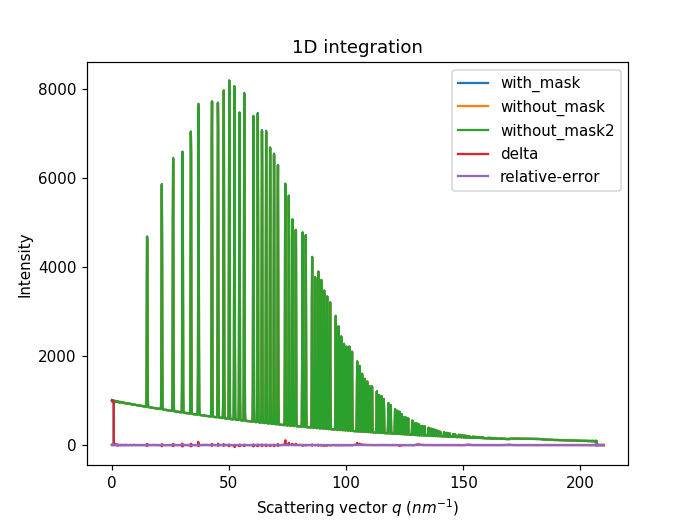

Between masked and non masked image R= 5.685933187504605
Between two different non-masked images R'= 0.3221558790311743


In [5]:
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo2 = ai.integrate1d(img_nomask2, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wm = ai.integrate1d(img, 2000, unit="q_nm^-1", method="splitpixel", mask=mask, radial_range=(0,210))
ax = jupyter.plot1d(wm , label="with_mask")
ax.plot(*wo, label="without_mask")
ax.plot(*wo2, label="without_mask2")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.plot(wo.radial, wo.intensity-wo2.intensity, label="relative-error")
ax.legend()
print("Between masked and non masked image R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))
print("Between two different non-masked images R'= %s"%pyFAI.utils.mathutil.rwp(wo2,wo))

<IPython.core.display.Javascript object>


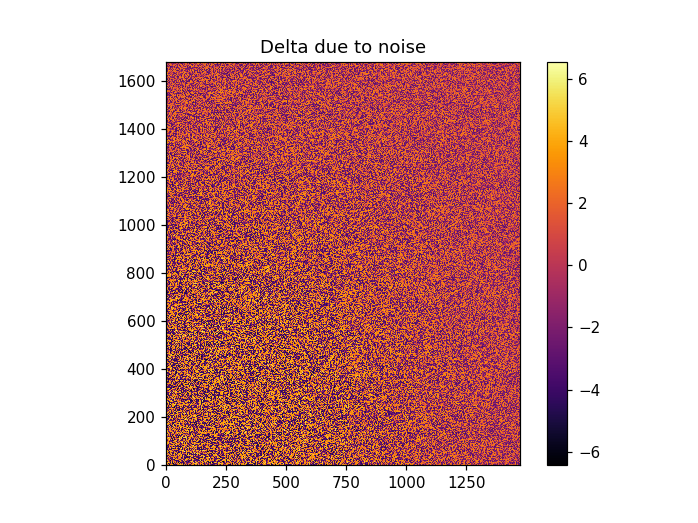

In [6]:
# Effect of the noise on the delta image
fig, ax = subplots()
jupyter.display(img=img_nomask-img_nomask2, label="Delta due to noise", ax=ax)
ax.figure.colorbar(ax.images[0])

## Inpainting

This part describes how to paint the missing pixels for having a "natural-looking image". The delta image contains the difference with the original image

<IPython.core.display.Javascript object>


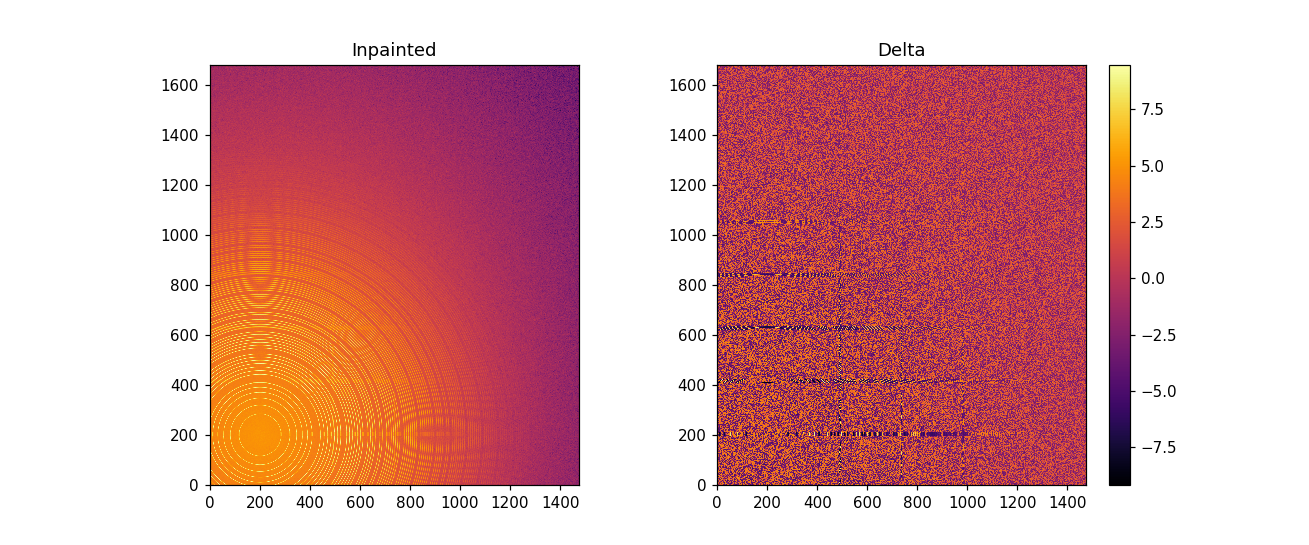

In [7]:
#Inpainting:
inpainted = ai.inpainting(img, mask=mask, poissonian=True)
fig, ax = subplots(1, 2, figsize=(12,5))
jupyter.display(img=inpainted, label="Inpainted", ax=ax[0])
jupyter.display(img=img_nomask-inpainted, label="Delta", ax=ax[1])
ax[1].figure.colorbar(ax[1].images[0])

<IPython.core.display.Javascript object>


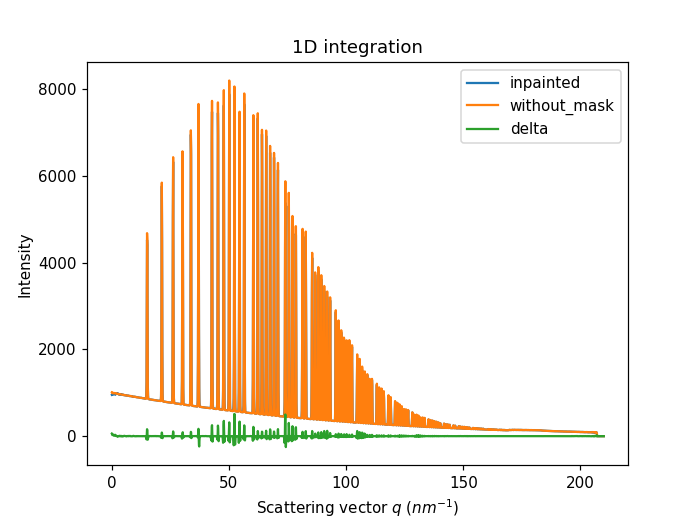

R= 1.349619188351499


In [8]:
# Comparison of the inpained image with the original one:
wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
ax = jupyter.plot1d(wm , label="inpainted")
ax.plot(*wo, label="without_mask")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.legend()
print("R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))

One can see by zooming in that the main effect on inpainting is a broadening of the signal in the inpainted region. This could (partially) be adressed by increasing the number of radial bins used in the inpainting.

## Benchmarking and optimization of the parameters

The parameter set depends on the detector, the experiment geometry and the type of signal on the detector. Finer detail require finer slicing.

In [9]:
#Basic benchmarking of execution time for default options:
% timeit inpainted = ai.inpainting(img, mask=mask)

481 ms ± 6.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
for j in ("csr", "csr_nosplit"):
    for k in (512,1024,2048, 4096):
        ai.reset()
        for i in range(10):
            inpainted = ai.inpainting(img, mask=mask, poissonian=True, method=j, npt_rad=k, grow_mask=i)
            wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
            print("method: %s npt_rad=%i grow=%i; R= %s"%(j, k, i,pyFAI.utils.mathutil.rwp(wm,wo)))

method: csr npt_rad=512 grow=0; R= 3.182480354413809
method: csr npt_rad=512 grow=1; R= 2.9248208755412515
method: csr npt_rad=512 grow=2; R= 2.7320238431922523
method: csr npt_rad=512 grow=3; R= 2.6773083253682675
method: csr npt_rad=512 grow=4; R= 2.6473850420934837
method: csr npt_rad=512 grow=5; R= 2.6041474031142453
method: csr npt_rad=512 grow=6; R= 2.5682143098253056
method: csr npt_rad=512 grow=7; R= 2.5737371695410607
method: csr npt_rad=512 grow=8; R= 2.566308730372569
method: csr npt_rad=512 grow=9; R= 2.555847369219145
method: csr npt_rad=1024 grow=0; R= 1.7200518211409552
method: csr npt_rad=1024 grow=1; R= 1.3720282432446913
method: csr npt_rad=1024 grow=2; R= 1.3666788820028286
method: csr npt_rad=1024 grow=3; R= 1.3497634623553838
method: csr npt_rad=1024 grow=4; R= 1.3291240851161308
method: csr npt_rad=1024 grow=5; R= 1.328806174410942
method: csr npt_rad=1024 grow=6; R= 1.326161041077948
method: csr npt_rad=1024 grow=7; R= 1.3226346130090094
method: csr npt_rad=1024 

method: csr npt_rad=4096 grow=9; R= 0.5574415640222186
method: csr_nosplit npt_rad=512 grow=0; R= 3.8547863294308633
method: csr_nosplit npt_rad=512 grow=1; R= 2.9759299327186253
method: csr_nosplit npt_rad=512 grow=2; R= 2.710156416470532
method: csr_nosplit npt_rad=512 grow=3; R= 2.645055850705422
method: csr_nosplit npt_rad=512 grow=4; R= 2.61076803896461
method: csr_nosplit npt_rad=512 grow=5; R= 2.6417593135097364
method: csr_nosplit npt_rad=512 grow=6; R= 2.617200766328301
method: csr_nosplit npt_rad=512 grow=7; R= 2.5729938846251343
method: csr_nosplit npt_rad=512 grow=8; R= 2.555956714979529


method: csr_nosplit npt_rad=512 grow=9; R= 2.558363901631384
method: csr_nosplit npt_rad=1024 grow=0; R= 2.808807876296065
method: csr_nosplit npt_rad=1024 grow=1; R= 1.4902839815335445
method: csr_nosplit npt_rad=1024 grow=2; R= 1.3725919089273906
method: csr_nosplit npt_rad=1024 grow=3; R= 1.3352716974099323
method: csr_nosplit npt_rad=1024 grow=4; R= 1.332725178408252
method: csr_nosplit npt_rad=1024 grow=5; R= 1.3349919066808218
method: csr_nosplit npt_rad=1024 grow=6; R= 1.2269246611571025
method: csr_nosplit npt_rad=1024 grow=7; R= 1.20774147785851
method: csr_nosplit npt_rad=1024 grow=8; R= 1.217259803610956


method: csr_nosplit npt_rad=1024 grow=9; R= 1.2247372462698145
method: csr_nosplit npt_rad=2048 grow=0; R= 2.853544081707163
method: csr_nosplit npt_rad=2048 grow=1; R= 1.3125319943849139
method: csr_nosplit npt_rad=2048 grow=2; R= 1.2060456065387812
method: csr_nosplit npt_rad=2048 grow=3; R= 1.1450251916252518
method: csr_nosplit npt_rad=2048 grow=4; R= 1.0770703883226123
method: csr_nosplit npt_rad=2048 grow=5; R= 0.9929002562365047
method: csr_nosplit npt_rad=2048 grow=6; R= 0.9305395768634485
method: csr_nosplit npt_rad=2048 grow=7; R= 0.8754889840133601
method: csr_nosplit npt_rad=2048 grow=8; R= 0.8878315780679752


method: csr_nosplit npt_rad=2048 grow=9; R= 0.8800428590343514
method: csr_nosplit npt_rad=4096 grow=0; R= 2.7249198961629673
method: csr_nosplit npt_rad=4096 grow=1; R= 1.296239112994906
method: csr_nosplit npt_rad=4096 grow=2; R= 1.2672253251472505
method: csr_nosplit npt_rad=4096 grow=3; R= 1.2489873055444116
method: csr_nosplit npt_rad=4096 grow=4; R= 1.226364859762778
method: csr_nosplit npt_rad=4096 grow=5; R= 1.2001431847772377
method: csr_nosplit npt_rad=4096 grow=6; R= 1.1831822061436006
method: csr_nosplit npt_rad=4096 grow=7; R= 1.1397720756380545
method: csr_nosplit npt_rad=4096 grow=8; R= 1.101579617062921
method: csr_nosplit npt_rad=4096 grow=9; R= 1.0656515660827397


CPU times: user 3.37 s, sys: 388 ms, total: 3.76 s
Wall time: 1.05 s


<IPython.core.display.Javascript object>


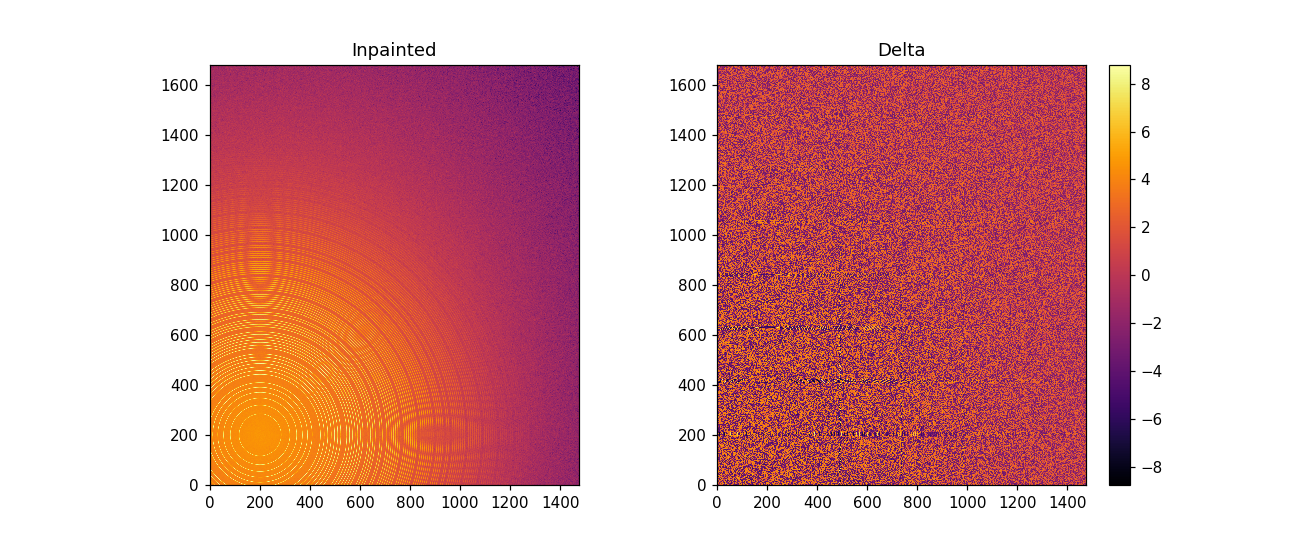

In [11]:
#Inpainting, best solution found:
ai.reset()
%time inpainted = ai.inpainting(img, mask=mask, poissonian=True, method="csr", npt_rad=4096, grow_mask=5)
fig, ax = subplots(1, 2, figsize=(12,5))
jupyter.display(img=inpainted, label="Inpainted", ax=ax[0])
jupyter.display(img=img_nomask-inpainted, label="Delta", ax=ax[1])
ax[1].figure.colorbar(ax[1].images[0])

<IPython.core.display.Javascript object>


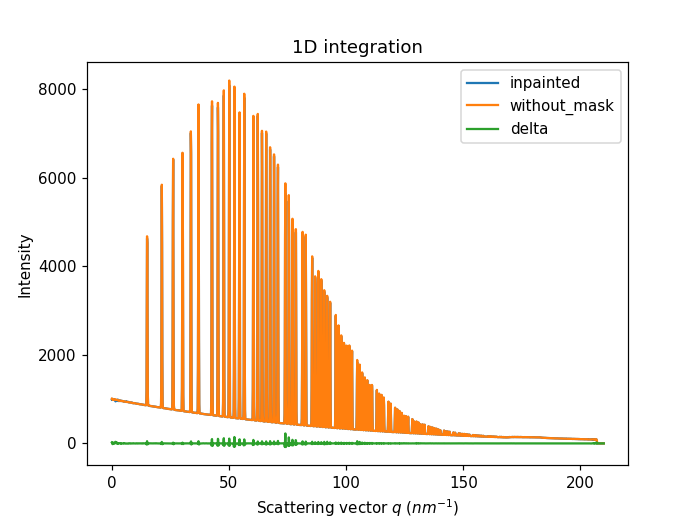

R= 0.5565489448896502


In [12]:
# Comparison of the inpained image with the original one:
wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
ax = jupyter.plot1d(wm , label="inpainted")
ax.plot(*wo, label="without_mask")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.legend()
print("R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))

## Conclusion

Inpainting is one of the only solution to fill up the gaps in detector when Fourier analysis is needed. 
This tutorial explains basically how this is possible using the pyFAI library and how to optimize the parameter set for inpainting. The result may greatly vary with detector position and tilt and the kind of signal (amorphous or more spotty).

In [13]:
print("Execution time: %.3fs"%(time.time()-start_time))

Execution time: 56.687s
